# Topic Analysis

This notebook analyzes the commentedPool.json file from the 2025.04.05 ToPeraicaLiska folder to extract and analyze topics.

In [1]:
# Import required libraries
import json
import pandas as pd
from pathlib import Path
from tqdm import tqdm
import logging

# Set up logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

In [2]:
# Define paths
DATA_DIR = Path('../2025.04.05 ToPeraicaLiska')
JSON_FILE = DATA_DIR / 'commentedPool.json'

# Check if file exists
if not JSON_FILE.exists():
    raise FileNotFoundError(f"File {JSON_FILE} not found")

logger.info(f"Reading JSON file: {JSON_FILE}")

INFO:__main__:Reading JSON file: ../2025.04.05 ToPeraicaLiska/commentedPool.json


In [27]:
# Function to read large JSON file in chunks with a limit
def read_json_in_chunks(file_path, chunk_size=1000, max_entries=2000):
    with open(file_path, 'r', encoding='utf-8') as f:
        data = []
        entry_count = 0
        
        # Read the file line by line
        current_entry = []
        bracket_count = 0
        
        for line in tqdm(f, desc="Reading JSON file"):
            if entry_count >= max_entries:
                break
                
            line = line.strip()
            if not line:
                continue
                
            # Count brackets in the line
            bracket_count += line.count('{') - line.count('}')
            current_entry.append(line)
            
            # If we've closed all brackets, we have a complete entry
            if bracket_count == 0 and current_entry:
                try:
                    entry_str = ''.join(current_entry)
                    # Remove trailing comma if present
                    if entry_str.endswith(','):
                        entry_str = entry_str[:-1]
                    entry = json.loads(entry_str)
                    data.append(entry)
                    entry_count += 1
                    
                    if len(data) >= chunk_size:
                        yield data
                        data = []
                    
                    current_entry = []
                except json.JSONDecodeError:
                    current_entry = []
                    continue
    
    if data:
        yield data

In [30]:
# Read and process the JSON file
all_data = []
for chunk in read_json_in_chunks(JSON_FILE, max_entries=2000000):
    all_data.extend(chunk)

logger.info(f"Total number of records: {len(all_data)}")

Reading JSON file: 15517824it [00:07, 2156821.28it/s]
INFO:__main__:Total number of records: 10610


In [31]:
# Process the data into separate DataFrames for articles and comments
articles = []
comments = []
article_id_counter = 0  # Start counter at 0
article_id_map = {}  # Map to store original docId to our new article_id

for entry in all_data:
    # Extract article
    article = entry['article']
    original_doc_id = article['docId']
    
    # Assign new article_id and store mapping
    article['article_id'] = article_id_counter
    article_id_map[original_doc_id] = article_id_counter
    articles.append(article)
    
    # Extract comments
    for comment in entry['comments']:
        # Use the mapping to get the correct article_id
        comment['article_id'] = article_id_map[original_doc_id]
        comments.append(comment)
    
    article_id_counter += 1  # Increment counter for next article

# Create DataFrames
articles_df = pd.DataFrame(articles)
comments_df = pd.DataFrame(comments)

# Display basic information
print("Articles DataFrame:")
print(f"Shape: {articles_df.shape}")
print("\nColumns:")
print(articles_df.columns.tolist())
print("\nFirst few rows:")
print(articles_df[['docId', 'article_id', 'title']].head())

print("\n\nComments DataFrame:")
print(f"Shape: {comments_df.shape}")
print("\nColumns:")
print(comments_df.columns.tolist())
print("\nFirst few rows:")
print(comments_df[['docId', 'article_id', 'title']].head())

# Verify the mapping worked correctly
print("\nVerification:")
print(f"Total number of unique articles: {article_id_counter}")
print(f"Number of articles in articles_df: {len(articles_df)}")
print(f"Number of unique article_ids in comments_df: {comments_df['article_id'].nunique()}")

Articles DataFrame:
Shape: (10610, 11)

Columns:
['docId', 'docCode', 'docType', 'author', 'publishDate', 'url', 'title', 'content', 'attributes', 'docIdx', 'article_id']

First few rows:
       docId  article_id                                              title
0  351534149           0      Soudci, kteří dali podmínku znásilňujícímu...
1  410397749           1  Opilec na elektrokoloběžce smetl v Brně na cho...
2  410397754           2  Český dobrodruh jde pěšky od Pacifiku k Atlant...
3  410397756           3  KVÍZ: Škoda Felicia slaví 30 let, jak dobře ji...
4  410397761           4  Jsem větší značka než Barrandov, řekl Soukup. ...


Comments DataFrame:
Shape: (348047, 13)

Columns:
['docId', 'docCode', 'docType', 'author', 'publishDate', 'url', 'title', 'content', 'attributes', 'docIdx', 'article_id', 'replyToAuthor', 'replyToDocId']

First few rows:
       docId  article_id                                              title
0  410398114           0  Soudci, kteří dali podmínku zn

In [32]:
# Read and process the topic clustering file
TOPICS_FILE = Path('../2025.04.05 ToPeraicaLiska/Topics/topicEVOC_artClusterText_KeyBERT_0.txt')

# Initialize a dictionary to store article IDs and their clusters
article_id_to_cluster = {}
current_cluster = None
current_label = None

# First, add cluster columns to articles_df with default values
articles_df['cluster_id'] = -1
articles_df['cluster_label'] = 'Unlabelled'

# Process the topic clustering file
with open(TOPICS_FILE, 'r', encoding='utf-8') as f:
    for line in f:
        line = line.strip()
        if not line or line.startswith('='):  # Skip empty lines and separator lines
            continue
            
        # Check if line starts with "cluster" to identify new clusters
        if line.startswith('cluster'):
            # Extract cluster number and label
            parts = line.split(':')
            cluster_info = parts[0].split()
            current_cluster = int(cluster_info[1])
            current_label = parts[1].strip()
        elif line.startswith('** Article'):
            # Extract article ID from the line
            # Format: ** Article X: [title...]
            parts = line.split(':', 1)  # Split only on first colon
            article_part = parts[0].strip()
            try:
                article_id = int(article_part.split()[2])  # Get the X from "** Article X"
                
                # Store the article ID to cluster mapping
                article_id_to_cluster[article_id] = (current_cluster, current_label)
            except (ValueError, IndexError):
                # Skip if we can't parse the article ID
                continue

# Apply clusters to articles_df
for article_id, (cluster_id, label) in article_id_to_cluster.items():
    # Find matching rows in articles_df and update them
    match_idx = articles_df.index[articles_df['article_id'] == article_id].tolist()
    if match_idx:
        articles_df.loc[match_idx, 'cluster_id'] = cluster_id
        articles_df.loc[match_idx, 'cluster_label'] = label

# Now add cluster information to comments_df based on article_id
comments_df['cluster_id'] = -1
comments_df['cluster_label'] = 'Unlabelled'

# Create a mapping from article_id to cluster info for efficiency
article_id_to_cluster_df = {}
for _, row in articles_df.iterrows():
    article_id_to_cluster_df[row['article_id']] = (row['cluster_id'], row['cluster_label'])

# Apply the mapping to comments
for idx, row in comments_df.iterrows():
    article_id = row['article_id']
    if article_id in article_id_to_cluster_df:
        cluster_id, cluster_label = article_id_to_cluster_df[article_id]
        comments_df.at[idx, 'cluster_id'] = cluster_id
        comments_df.at[idx, 'cluster_label'] = cluster_label

# Display basic statistics about the cluster assignments
print("\nArticles with cluster information:")
print(f"Number of articles with assigned clusters: {(articles_df['cluster_id']).sum()}")
print(f"Number of unique clusters in articles: {articles_df['cluster_id'].nunique()}")
print("\nFirst few rows of articles with clusters:")
print(articles_df[['article_id', 'title', 'cluster_id', 'cluster_label']].head())

print("\n\nComments with cluster information:")
print(f"Number of comments with assigned clusters: {(comments_df['cluster_id']).sum()}")
print(f"Number of unique clusters in comments: {comments_df['cluster_id'].nunique()}")
print("\nFirst few rows of comments with clusters:")
print(comments_df[['article_id', 'title', 'cluster_id', 'cluster_label']].head())


Articles with cluster information:
Number of articles with assigned clusters: 490601
Number of unique clusters in articles: 198

First few rows of articles with clusters:
   article_id                                              title  cluster_id  \
0           0      Soudci, kteří dali podmínku znásilňujícímu...          -1   
1           1  Opilec na elektrokoloběžce smetl v Brně na cho...          -1   
2           2  Český dobrodruh jde pěšky od Pacifiku k Atlant...         123   
3           3  KVÍZ: Škoda Felicia slaví 30 let, jak dobře ji...          -1   
4           4  Jsem větší značka než Barrandov, řekl Soukup. ...         106   

               cluster_label  
0           12037 Unlabelled  
1           12037 Unlabelled  
2  106 šampionát rekordmanka  
3           12037 Unlabelled  
4          66 médiím tálibán  


Comments with cluster information:
Number of comments with assigned clusters: 18075804
Number of unique clusters in comments: 197

First few rows of comments w

In [33]:
# Calculate and display statistics with all clusters (including -1) as valid
total_comments = len(comments_df)

print(f"\nCluster Assignment Statistics:")
print(f"Total comments: {total_comments}")
print(f"All comments have been assigned to clusters (including Unlabelled)")

# Calculate cluster distribution
cluster_distribution = comments_df['cluster_id'].value_counts().sort_index()
cluster_label_mapping = {}
for _, row in articles_df.iterrows():
    if row['cluster_id'] not in cluster_label_mapping:
        cluster_label_mapping[row['cluster_id']] = row['cluster_label']

# Ensure -1 is in the mapping
if -1 not in cluster_label_mapping:
    cluster_label_mapping[-1] = "Unlabelled"

print("\nDistribution of comments across clusters:")
for cluster_id, count in cluster_distribution.items():
    label = cluster_label_mapping.get(cluster_id, "Unknown")
    print(f"Cluster {cluster_id} ({label}): {count} comments ({count/len(comments_df)*100:.2f}%)")


Cluster Assignment Statistics:
Total comments: 348047
All comments have been assigned to clusters (including Unlabelled)

Distribution of comments across clusters:
Cluster -1 (12037 Unlabelled): 165565 comments (47.57%)
Cluster 0 (33 trumpovu mohl): 9 comments (0.00%)
Cluster 1 (29 papež náboženským): 1156 comments (0.33%)
Cluster 2 (48 princezna svatby): 141 comments (0.04%)
Cluster 3 (37 jihokorejskému zatčením): 751 comments (0.22%)
Cluster 4 (38 severokorejští raket): 69 comments (0.02%)
Cluster 5 (64 putinovo rusům): 998 comments (0.29%)
Cluster 6 (34 požárům kalifornie): 57 comments (0.02%)
Cluster 7 (34 nevidomí nepozornosti): 115 comments (0.03%)
Cluster 8 (27 škvoreckého rusové): 168 comments (0.05%)
Cluster 9 (23 aerolinkách cathay): 178 comments (0.05%)
Cluster 10 (26 konzole videohry): 413 comments (0.12%)
Cluster 11 (103 ghostrunneru maskotem): 829 comments (0.24%)
Cluster 12 (38 pražském letadel): 554 comments (0.16%)
Cluster 13 (93 brazílii miliardářkou): 1175 comments 

In [34]:
# Group comments by user and find unique clusters per user
user_clusters = {}

# Process each comment to build the mapping
for _, comment in comments_df.iterrows():
    author = comment['author']
    cluster_id = comment['cluster_id']
    cluster_label = comment['cluster_label']
    
    # Initialize user entry if not exists
    if author not in user_clusters:
        user_clusters[author] = {
            'clusters': set(),  # Use a set to store unique clusters
            'cluster_details': {},  # Map clusters to their labels
            'comment_count': 0
        }
    
    # Add cluster to user's set
    user_clusters[author]['clusters'].add(cluster_id)
    user_clusters[author]['cluster_details'][cluster_id] = cluster_label
    user_clusters[author]['comment_count'] += 1

# Create DataFrame for analysis
user_data = []
for author, data in user_clusters.items():
    user_data.append({
        'author': author,
        'unique_clusters': len(data['clusters']),
        'clusters': list(data['clusters']),
        'cluster_labels': [data['cluster_details'][c] for c in data['clusters']],
        'comment_count': data['comment_count']
    })

user_cluster_df = pd.DataFrame(user_data)

# Sort by number of unique clusters (descending)
user_cluster_df = user_cluster_df.sort_values(by='unique_clusters', ascending=False)

# Display statistics
print(f"Total number of users: {len(user_cluster_df)}")
print("\nDistribution of users by number of clusters they post to:")
cluster_count_distribution = user_cluster_df['unique_clusters'].value_counts().sort_index()
for count, num_users in cluster_count_distribution.items():
    percentage = (num_users / len(user_cluster_df)) * 100
    print(f"Users posting to {count} different clusters: {num_users} ({percentage:.2f}%)")

# Show top users who post to the most clusters
print("\nTop 10 users who post to the most different clusters:")
top_users = user_cluster_df.head(10)
for idx, row in top_users.iterrows():
    print(f"User: {row['author']}")
    print(f"  Posts to {row['unique_clusters']} different clusters")
    print(f"  Total comments: {row['comment_count']}")
    
    # List the top 5 clusters (if they have more than 5)
    clusters_to_show = min(5, len(row['clusters']))
    if clusters_to_show < len(row['clusters']):
        print(f"  Top {clusters_to_show} clusters (out of {len(row['clusters'])}):")
    else:
        print(f"  Clusters:")
    
    for i in range(clusters_to_show):
        cluster_id = row['clusters'][i]
        label = row['cluster_labels'][i]
        print(f"    - Cluster {cluster_id}: {label}")
    print()

Total number of users: 47657

Distribution of users by number of clusters they post to:
Users posting to 1 different clusters: 21351 (44.80%)
Users posting to 2 different clusters: 7898 (16.57%)
Users posting to 3 different clusters: 4460 (9.36%)
Users posting to 4 different clusters: 3021 (6.34%)
Users posting to 5 different clusters: 2033 (4.27%)
Users posting to 6 different clusters: 1498 (3.14%)
Users posting to 7 different clusters: 1167 (2.45%)
Users posting to 8 different clusters: 921 (1.93%)
Users posting to 9 different clusters: 744 (1.56%)
Users posting to 10 different clusters: 598 (1.25%)
Users posting to 11 different clusters: 450 (0.94%)
Users posting to 12 different clusters: 429 (0.90%)
Users posting to 13 different clusters: 367 (0.77%)
Users posting to 14 different clusters: 299 (0.63%)
Users posting to 15 different clusters: 257 (0.54%)
Users posting to 16 different clusters: 234 (0.49%)
Users posting to 17 different clusters: 214 (0.45%)
Users posting to 18 differe

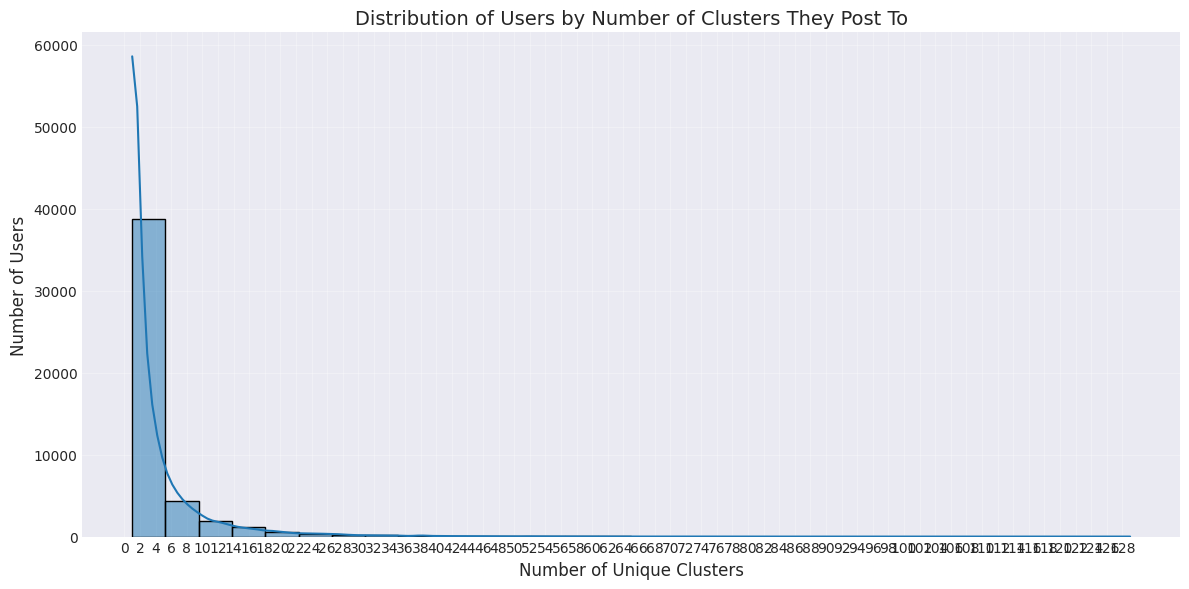

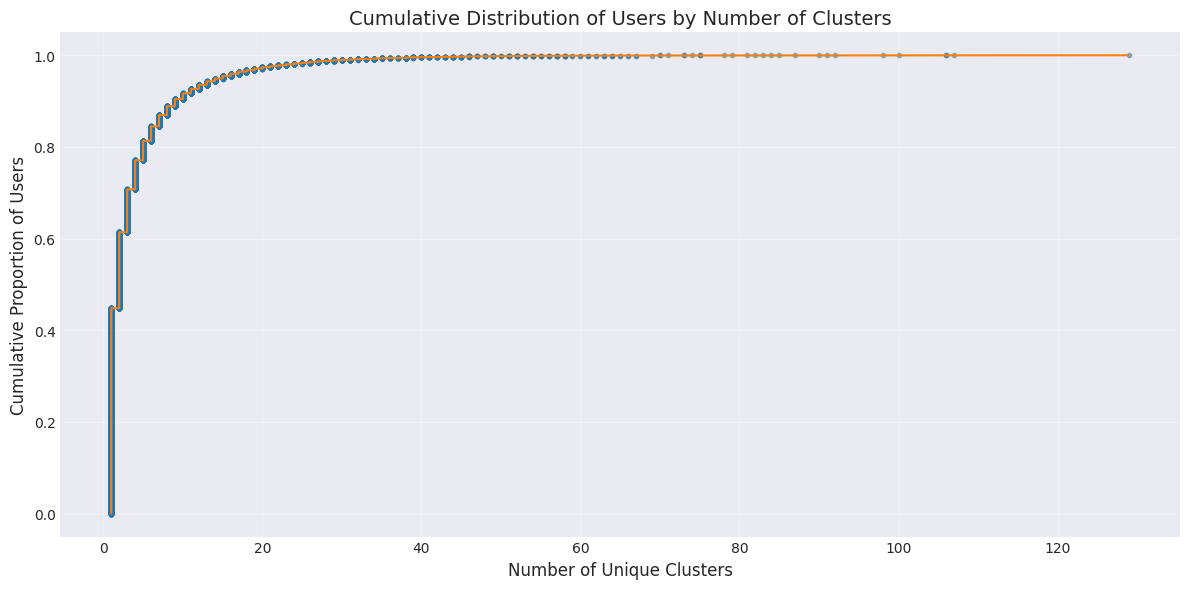

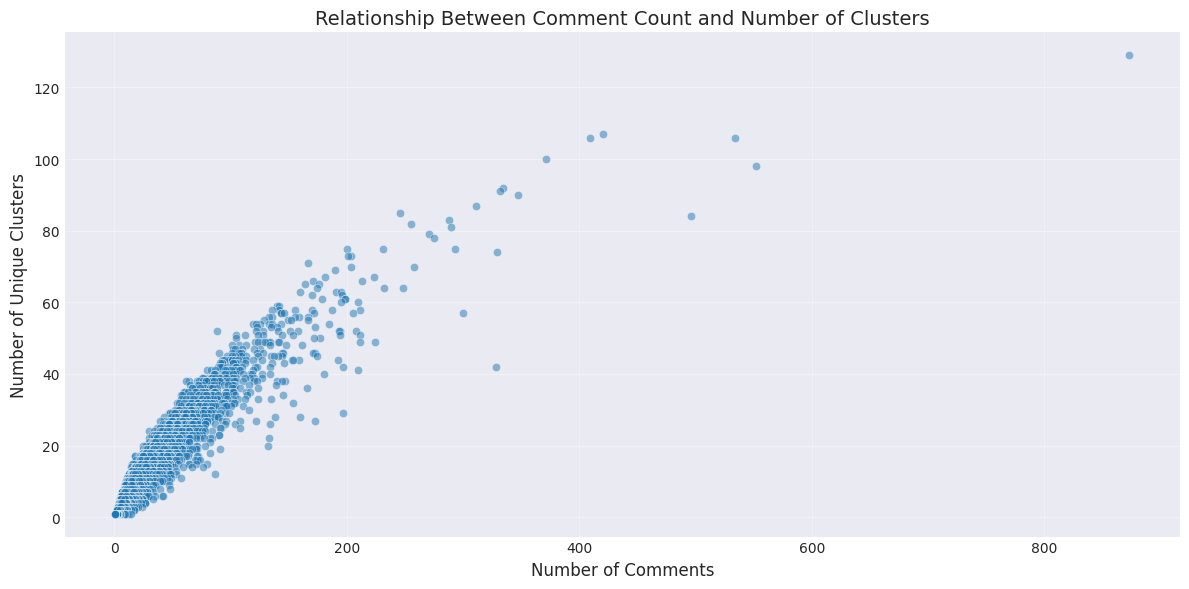

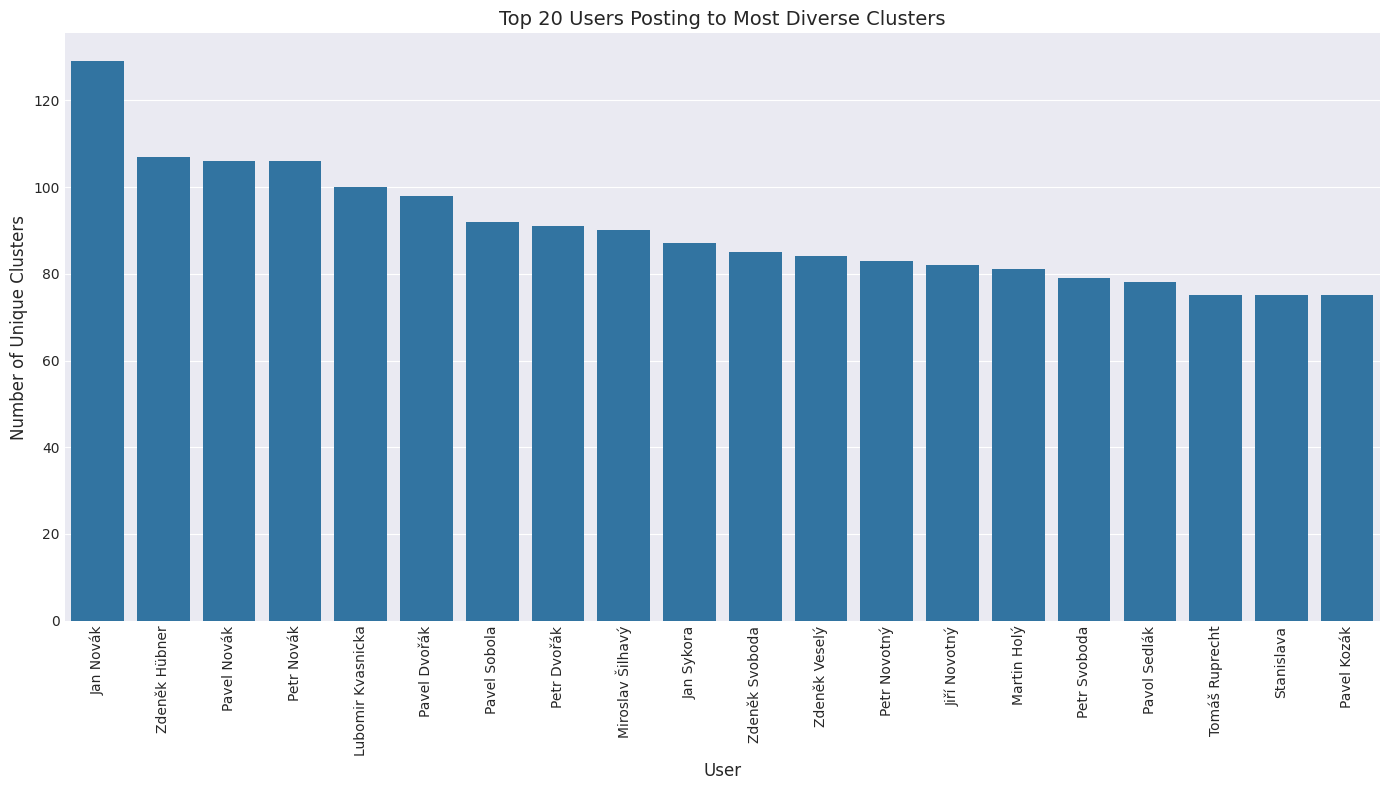

Summary Statistics for Unique Clusters per User:
count    47657.000000
mean         3.961328
std          6.100530
min          1.000000
25%          1.000000
50%          2.000000
75%          4.000000
max        129.000000
Name: unique_clusters, dtype: float64

Percentage of users by number of clusters:
1 clusters: 44.80%
2 clusters: 16.57%
3 clusters: 9.36%
4 clusters: 6.34%
5 clusters: 4.27%
6 clusters: 3.14%
7 clusters: 2.45%
8 clusters: 1.93%
9 clusters: 1.56%
10 clusters: 1.25%
11 clusters: 0.94%
12 clusters: 0.90%
13 clusters: 0.77%
14 clusters: 0.63%
15 clusters: 0.54%
16 clusters: 0.49%
17 clusters: 0.45%
18 clusters: 0.34%
19 clusters: 0.36%
20 clusters: 0.27%
21 clusters: 0.24%
22 clusters: 0.19%
23 clusters: 0.20%
24 clusters: 0.19%
25 clusters: 0.18%
26 clusters: 0.15%
27 clusters: 0.17%
28 clusters: 0.12%
29 clusters: 0.10%
30 clusters: 0.07%
31 clusters: 0.08%
32 clusters: 0.09%
33 clusters: 0.05%
34 clusters: 0.08%
35 clusters: 0.06%
36 clusters: 0.04%
37 clusters: 0.0

In [36]:
# Import visualization libraries if not already imported
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Set a nice style for the plots
plt.style.use('seaborn-v0_8-darkgrid')

# Figure 1: Distribution of users by number of clusters
plt.figure(figsize=(12, 6))
sns.histplot(data=user_cluster_df, x='unique_clusters', kde=True, bins=30)
plt.title('Distribution of Users by Number of Clusters They Post To', fontsize=14)
plt.xlabel('Number of Unique Clusters', fontsize=12)
plt.ylabel('Number of Users', fontsize=12)
plt.xticks(range(0, max(user_cluster_df['unique_clusters'])+1, 2))
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Figure 2: Cumulative distribution function (CDF)
plt.figure(figsize=(12, 6))
# Sort values for CDF
sorted_values = np.sort(user_cluster_df['unique_clusters'].values)
# Get y values for CDF
yvals = np.arange(1, len(sorted_values)+1) / float(len(sorted_values))
# Plot CDF
plt.plot(sorted_values, yvals, marker='.', linestyle='none', alpha=0.5)
plt.plot(sorted_values, yvals, linestyle='-')
plt.title('Cumulative Distribution of Users by Number of Clusters', fontsize=14)
plt.xlabel('Number of Unique Clusters', fontsize=12)
plt.ylabel('Cumulative Proportion of Users', fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Figure 3: Scatter plot of unique clusters vs. comment count
plt.figure(figsize=(12, 6))
plt.scatter(user_cluster_df['comment_count'], user_cluster_df['unique_clusters'], 
            alpha=0.5, edgecolor='w', linewidth=0.5)
plt.title('Relationship Between Comment Count and Number of Clusters', fontsize=14)
plt.xlabel('Number of Comments', fontsize=12)
plt.ylabel('Number of Unique Clusters', fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Figure 4: Top 20 users with most diverse posting patterns
top_20_users = user_cluster_df.head(20)
plt.figure(figsize=(14, 8))
sns.barplot(data=top_20_users, x='author', y='unique_clusters')
plt.title('Top 20 Users Posting to Most Diverse Clusters', fontsize=14)
plt.xlabel('User', fontsize=12)
plt.ylabel('Number of Unique Clusters', fontsize=12)
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

# Print summary statistics
print("Summary Statistics for Unique Clusters per User:")
print(user_cluster_df['unique_clusters'].describe())

# Compute percentage of users by cluster count
cluster_counts = user_cluster_df['unique_clusters'].value_counts(normalize=True).sort_index() * 100
print("\nPercentage of users by number of clusters:")
for clusters, percentage in cluster_counts.items():
    print(f"{clusters} clusters: {percentage:.2f}%")

In [38]:
# Get article examples for the top cluster-diverse users (3 clusters per user)

# Get the 5 most diverse users (those who post to the most clusters)
top_users = user_cluster_df.head(5)['author'].tolist()

article_examples = {}

# For each top user, find one example article from each cluster they post to
for user in top_users:
    # Filter comments for this user
    user_comments = comments_df[comments_df['author'] == user]
    
    # Group by cluster_id and get one example article from each
    clusters = {}
    for cluster_id in user_comments['cluster_id'].unique():
        # Get one comment from this cluster
        comment = user_comments[user_comments['cluster_id'] == cluster_id].iloc[0]
        
        # Get the article information
        article_id = comment['article_id']
        article = articles_df[articles_df['article_id'] == article_id].iloc[0]
        
        clusters[int(cluster_id)] = {
            'article_title': article['title'],
            'cluster_label': comment['cluster_label']
        }
    
    article_examples[user] = clusters

# Display the results
for user, clusters in article_examples.items():
    print(f"User: {user}")
    print(f"Posted across {len(clusters)} clusters. Example articles (3 of {len(clusters)}):")
    
    # Get user's cluster count from our earlier dataframe
    user_data = user_cluster_df[user_cluster_df['author'] == user].iloc[0]
    
    # Sort clusters by cluster ID
    sorted_clusters = sorted(clusters.items())
    
    # Print exactly 3 examples (or fewer if user has posted to fewer clusters)
    for i, (cluster_id, data) in enumerate(sorted_clusters[:3]):
        print(f"  Cluster {cluster_id} ({data['cluster_label']}):")
        print(f"    Article: {data['article_title']}")
    
    print(f"  Total comments by user: {user_data['comment_count']}")
    print()

User: Jan Novák
Posted across 129 clusters. Example articles (3 of 129):
  Cluster -1 (12037 Unlabelled):
    Article: Soudci, kteří dali podmínku znásilňujícímu...
  Cluster 5 (64 putinovo rusům):
    Article: Na nové dálnici D4 budou řidiči pod neustálým dohledem dvou stovek kamer a několika radarů
  Cluster 9 (23 aerolinkách cathay):
    Article: Historický okamžik. Osmdesát let od představení vrtulníků vzniká nová kategorie letadel
  Total comments by user: 873

User: Zdeněk Hübner
Posted across 107 clusters. Example articles (3 of 107):
  Cluster -1 (12037 Unlabelled):
    Article: Už žádná Moskva. Malíř obnovil ve Žďárských...
  Cluster 2 (48 princezna svatby):
    Article: V Rusku jmenovali do regionální vlády vojáka, kterého Kyjev stíhá za vraždění civilistů v Buči
  Cluster 3 (37 jihokorejskému zatčením):
    Article: Dobrý a produktivní rozhovor o Ukrajině, pochvaloval si Trump
  Total comments by user: 420

User: Pavel Novák
Posted across 106 clusters. Example articles (3 of